# Statistical analysis
In this notebook, we do statistical analysis of the results

In [44]:
import os
import json
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]

In [46]:
scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
tasks = scores.keys()
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

# we make a subset consisting of only the languages for which an adapter exists
scores_subset = {}
no_adapter = {}
for task_name in scores:
    scores_subset[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in existing_adapters:
            scores_subset[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]

for task in tasks:
    print(f"task: {task}, {len(scores[task])} languages")
    print(f"{len(scores_subset[task])} have a trained language adapter, {len(no_adapter[task])} not")
    print(f"{len(xlm_included[task])} are in the xlm included languages, {len(xlm_not_included[task])} not")

task: ner, 156 languages
30 have a trained language adapter, 126 not
94 are in the xlm included languages, 62 not
task: pos, 90 languages
19 have a trained language adapter, 71 not
59 are in the xlm included languages, 31 not
task: copa, 11 languages
11 have a trained language adapter, 0 not
11 are in the xlm included languages, 0 not
task: qa, 12 languages
11 have a trained language adapter, 1 not
12 are in the xlm included languages, 0 not


In [24]:
def get_significance(task_name, option1, option2, alternative="two-sided", data=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = data.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in data[task_name]:
            if option1 in data[task_name][lang_name] and option2 in data[task_name][lang_name]:
                score1 = data[task_name][lang_name][option1]
                score2 = data[task_name][lang_name][option2]
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val

# 1. Overall scores
We take together all tasks, and check if our method is better than the baselines.
This gives more weight to NER, followed by POS, and much less to QA and COPA as they have less overall datapoints to consider.
--> We will present an analysis per task later on.

In [ ]:
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_en", "baseline_avg_adapter", "baseline_closest_featural", "no_train_gain"]

sign = []
not_sign = []
for baseline in baselines:
    print(f"ALL tasks, baseline {baseline}")
    t_stat, p_val = get_significance("all", test_column, baseline, alternative="greater")
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append("all" + "_" + baseline)
    else:
        print("The difference is not statistically significant")
        not_sign.append("all" + "_" + baseline)
    print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

# 2. Task-specific scores
Per task, we look how the method compares to the baselines.

In [25]:
tasks = ["ner", "pos", "copa", "qa"]
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_en", "baseline_avg_adapter", "baseline_closest_featural", "no_train_gain"]

sign = []
not_sign = []
for baseline in baselines:
    for task in tasks:
        print(f"task: {task}, baseline {baseline}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative="greater")
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: ner, baseline finetune
average scores
reconstructed_featural: 0.5013399275268126
finetune: 0.3915923233860745
t-statistic: 16.291464164268035
p-value: 1.081066709663728e-33
The difference is statistically significant
-----------------------------------
task: pos, baseline finetune
average scores
reconstructed_featural: 0.4679441087506307
finetune: 0.40026520216883055
t-statistic: 10.974986167656738
p-value: 7.405997011212951e-18
The difference is statistically significant
-----------------------------------
task: copa, baseline finetune
average scores
reconstructed_featural: 0.5498181818181818
finetune: 0.5552727272727273
t-statistic: -0.7693825361789232
p-value: 0.7702733142031852
The difference is not statistically significant
-----------------------------------
task: qa, baseline finetune
average scores
reconstructed_featural: 0.7271252762822759
finetune: 0.5336718068640248
t-statistic: 6.1154369971595575
p-value: 3.784708366946107e-05
The difference is statistically significa

## POS comparison

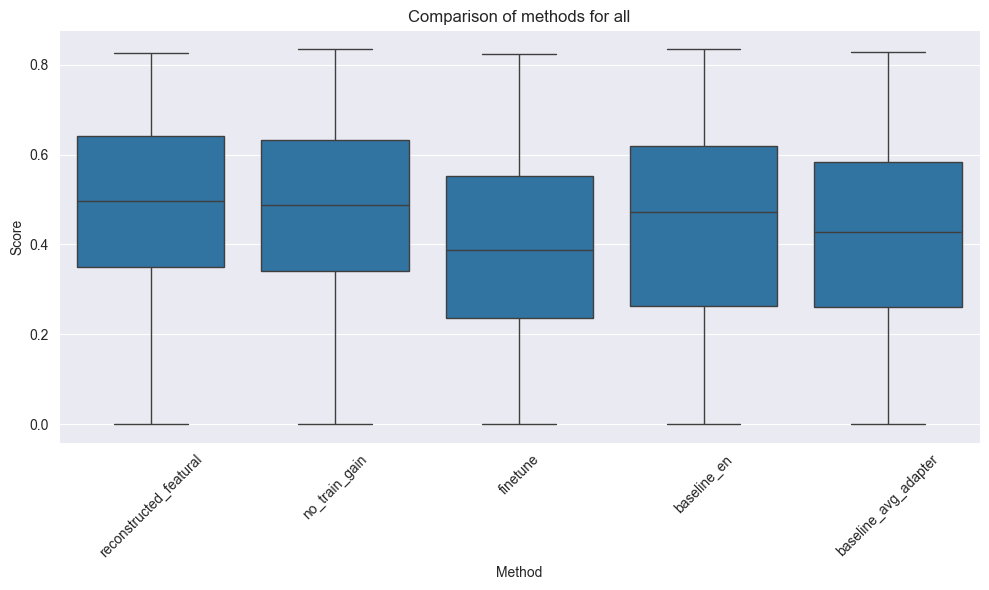

In [7]:
tasks = ["ner", "pos", "copa", "qa"]


def make_boxplot(tasks, columns):
    data = []
    if tasks == "all":
        task_names = scores.keys()
    elif len(tasks) == 1:
        task_names = [tasks]
    else:
        task_names = tasks
    for task in task_names:
        for lang_name in scores[task]:
            if all(col in scores[task][lang_name] for col in columns):
                data.append([task, lang_name] + [scores[task][lang_name][col] for col in columns])
    df = pd.DataFrame(data, columns=["task", "lang_name"] + columns)
    # we divide the scores of qa by 100
    df.loc[df["task"] == "qa", columns] = df.loc[df["task"] == "qa", columns] / 100
    # we melt the dataframe to get it in the right format for seaborn
    df_melted = df.melt(id_vars=["task", "lang_name"], value_vars=columns, var_name="method", value_name="score")
    # we plot the data
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="method", y="score", data=df_melted)
    plt.title(f"Comparison of methods for {tasks}")
    plt.xlabel("Method")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


make_boxplot("all", ["reconstructed_featural", "no_train_gain", "finetune", "baseline_en", "baseline_avg_adapter"])

task: ner, baseline reconstructed_syntactic_distVar
average scores
reconstructed_featural: 0.49205773743749875
reconstructed_syntactic_distVar: 0.4918442534411594
t-statistic: 1.0811171510619646
p-value: 0.28120374123854264
The difference is not statistically significant
-----------------------------------
task: ner, baseline reconstructed_morphological_distVar
average scores
reconstructed_featural: 0.49205773743749875
reconstructed_morphological_distVar: 0.4915979688005202
t-statistic: 1.3995781616088783
p-value: 0.16349448441716283
The difference is not statistically significant
-----------------------------------
task: ner, baseline reconstructed_featural_limit
average scores
reconstructed_featural: 0.49352616521371134
reconstructed_featural_limit: 0.49588941865154307
t-statistic: -1.49456079485828
p-value: 0.13691625427549192
The difference is not statistically significant
-----------------------------------
task: ner, baseline reconstructed_featural_threshold
average scores
recons

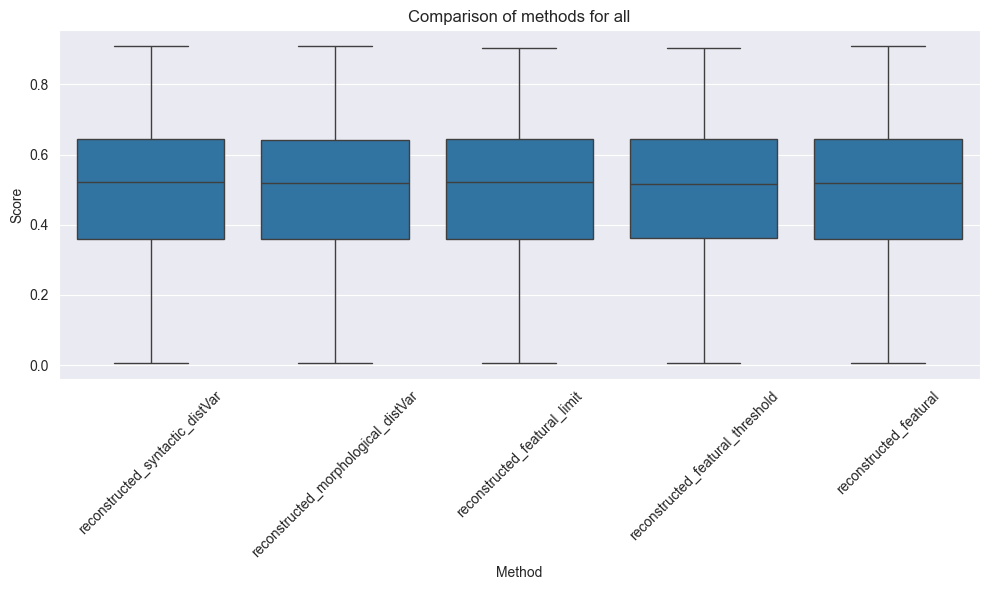

In [76]:
# comparison of "featural" vs other methods
test_column = "reconstructed_featural"
methods = [
    "reconstructed_syntactic_distVar",
    "reconstructed_morphological_distVar",
    "reconstructed_featural_limit",
    "reconstructed_featural_threshold",
]

for method in methods:
    print(f"task: {task}, baseline {method}")
    t_stat, p_val = get_significance("all", test_column, method)
    if p_val < 0.05:
        print("The difference is statistically significant")
    else:
        print("The difference is not statistically significant")
    print("-----------------------------------")
make_boxplot("all", methods + [test_column])

# Method extension
We check if "sr" and "eu" are better than "base", and if "extended" is better than them all

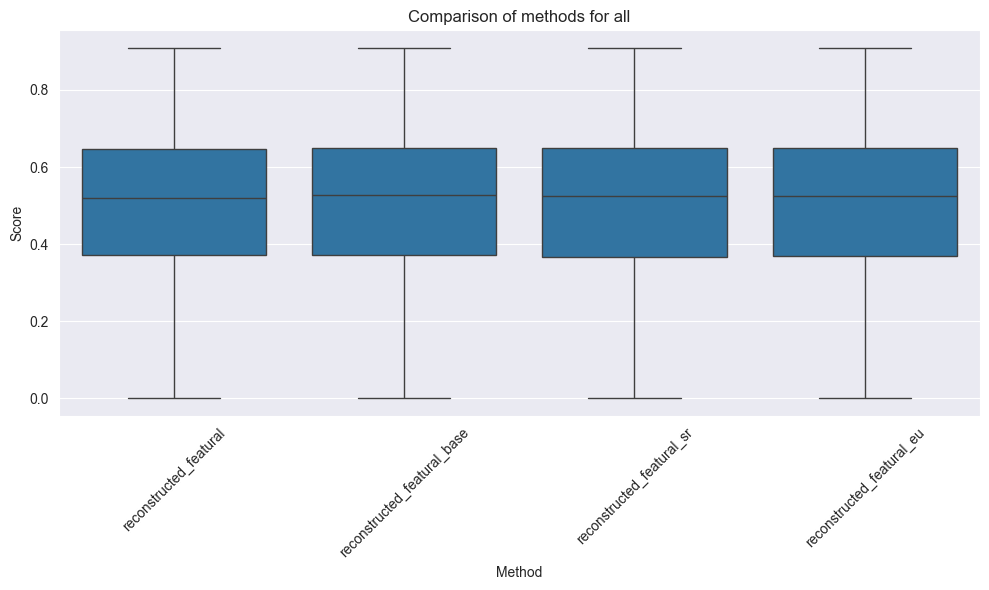

reconstructed_featural vs reconstructed_featural_base
average scores
reconstructed_featural_base: 0.5481909293506161
reconstructed_featural: 0.548038336816443
t-statistic: 0.21695009323508813
p-value: 0.8288874393042935
The difference is not statistically significant
-----------------------------------
reconstructed_featural_sr vs reconstructed_featural_base
average scores
reconstructed_featural_base: 0.549142830180154
reconstructed_featural_sr: 0.5485405968438358
t-statistic: 1.1937865260991705
p-value: 0.2365914932023204
The difference is not statistically significant
-----------------------------------
reconstructed_featural_eu vs reconstructed_featural_base
average scores
reconstructed_featural_base: 0.549142830180154
reconstructed_featural_eu: 0.5485029743001795
t-statistic: 1.3306420948713455
p-value: 0.1876252578851845
The difference is not statistically significant
-----------------------------------
ner:reconstructed_featural vs reconstructed_featural_base
average scores
recon

In [82]:
extended = "reconstructed_featural"
base = "reconstructed_featural_base"
sr = "reconstructed_featural_sr"
eu = "reconstructed_featural_eu"
make_boxplot("all", [extended, base, sr, eu])
# we check for statistical significance, if "base" is less than any of the others

for method in [extended, sr, eu]:
    print(f"{method} vs {base}")
    t_stat, p_val = get_significance("all", base, method, data=scores_subset)
    if p_val < 0.05:
        print("The difference is statistically significant")
    else:
        print("The difference is not statistically significant")
    print("-----------------------------------")
for task in tasks:
    for method in [extended]:
        print(f"{task}:{method} vs {base}")
        t_stat, p_val = get_significance(task, base, method, data=scores)
        if p_val < 0.05:
            print("The difference is statistically significant")
        else:
            print("The difference is not statistically significant")
        print("-----------------------------------")